# Strategy 

In this dataset, features are masked (numerically encoded) or categorical. Number of years in current city could be numeric but beyond 4 years, input values are '4+'.

The following discrete features are <u> numerically encoded </u> therefore we shall use one-hot encoding scheme:
- User_ID
- Occupation
- Marital_Status
- Product_Category_1, Product_Category_2, Product_Category_3

The following discrete features are 	<u> categorical </u> thus we need to binarize them (numeric then one-hot encoding):
- Product_ID
- Gender
- Age
- City_Category
- Stay_In_Current_City_Years

In [1]:
import pandas as pd
filename = './train_oSwQCTC/train.csv'
df = pd.read_csv(filename)

## Correlation
Let's see what correlation between features tells us before going further

<IPython.core.display.Javascript object>


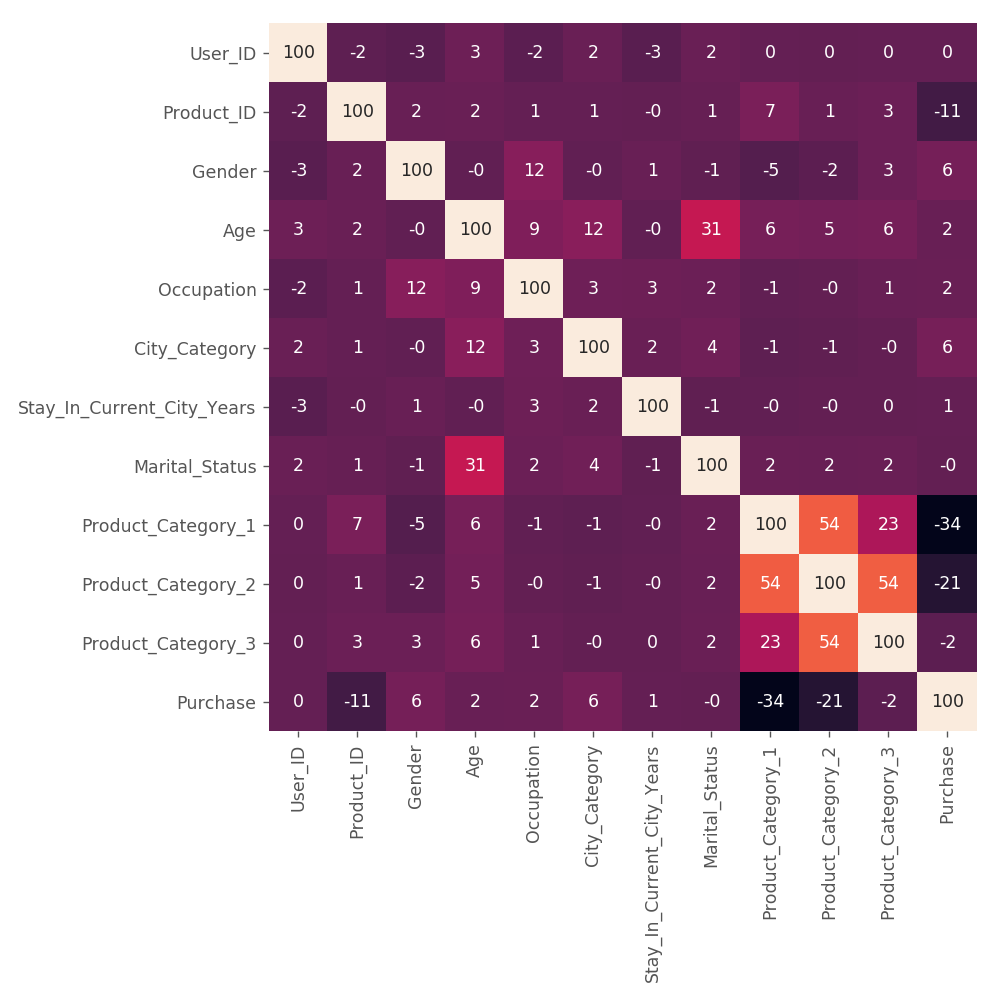

In [2]:
# start with a dataframe copy
df_cpy = df.copy()

# all data needs to be numeric to perform a correlation analysis
col2encode = ['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']
# convert non-numeric columns to numbers
for col in col2encode:
    df_cpy[col] = df_cpy[col].astype('category').cat.codes

# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# show correlation via seaborn
import seaborn as sn
_ , axsn = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn, square=False, fmt='.0f', annot=True, cbar=False)
# rotation represents the state of label's rotation (Note: doc says labelrotation but ignore it)
axsn.tick_params(axis = 'x',rotation = 90.0)
axsn.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

Product Category 1 and 2 seems to help predict purchase the most.  Product ID is third.

Regarding feature correlation, Product Category 1,2 and 3 should be combined as they are correlated with each other. Moreover there are missing values which can hold information.

Notice the following correlation too:<br>

* Age and Marital status is 31% correlated. (More likely yo be married if you are older) <br>
* Age and City category is 12% correlated. <br>
* Gender and Occupation is 12% correlated.<br>

Combine all product categories (1,2 and 3)

In [3]:
# first, convert to string 
temp_prod123 = df_cpy.loc[:,['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].astype(str)
# combine Prod cat123 and add it to dataframe
temp_prod123 = temp_prod123.Product_Category_1 + '-' + temp_prod123.Product_Category_2 + '-' + temp_prod123.Product_Category_3
df_cpy.insert(len(df_cpy.columns)-1, 'Prod_cat123', temp_prod123)
# remove prod cat 1,2 and 3 from dataframe
df_cpy.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'], inplace=True, axis = 1)
# convert to numeric values again via category
df_cpy['Prod_cat123'] = df_cpy['Prod_cat123'].astype('category').cat.codes

Even out Age distribution prior to consolidating with Marital status

In [4]:
# even out age first (see Introduction and Data Exploration notebook)
df_cpy.Age = df.Age.replace(['0-17', '18-25'], '0-25')
df_cpy.Age.replace(['46-50', '51-55', '55+'], '46+', inplace = True)
df_cpy.Age.value_counts()

26-35    219587
0-25     114762
36-45    110013
46+      105706
Name: Age, dtype: int64

Age range 26-35 is still dominant but this is the best we can do unless we split it randomly in two parts or use Kmeans!

In [5]:
temp_age_mar = df_cpy.loc[:,['Age', 'Marital_Status']].astype(str)
temp_age_mar = temp_age_mar.Marital_Status + '-' + temp_age_mar.Age
df_cpy.insert(df_cpy.columns.get_loc('Age'), 'Marital_Status_Age', temp_age_mar)
df_cpy.drop(labels = ['Age','Marital_Status'], inplace=True, axis = 1)
# convert to numeric values
df_cpy['Marital_Status_Age'] = df_cpy['Marital_Status_Age'].astype('category').cat.codes

Plot updated correlation

<IPython.core.display.Javascript object>


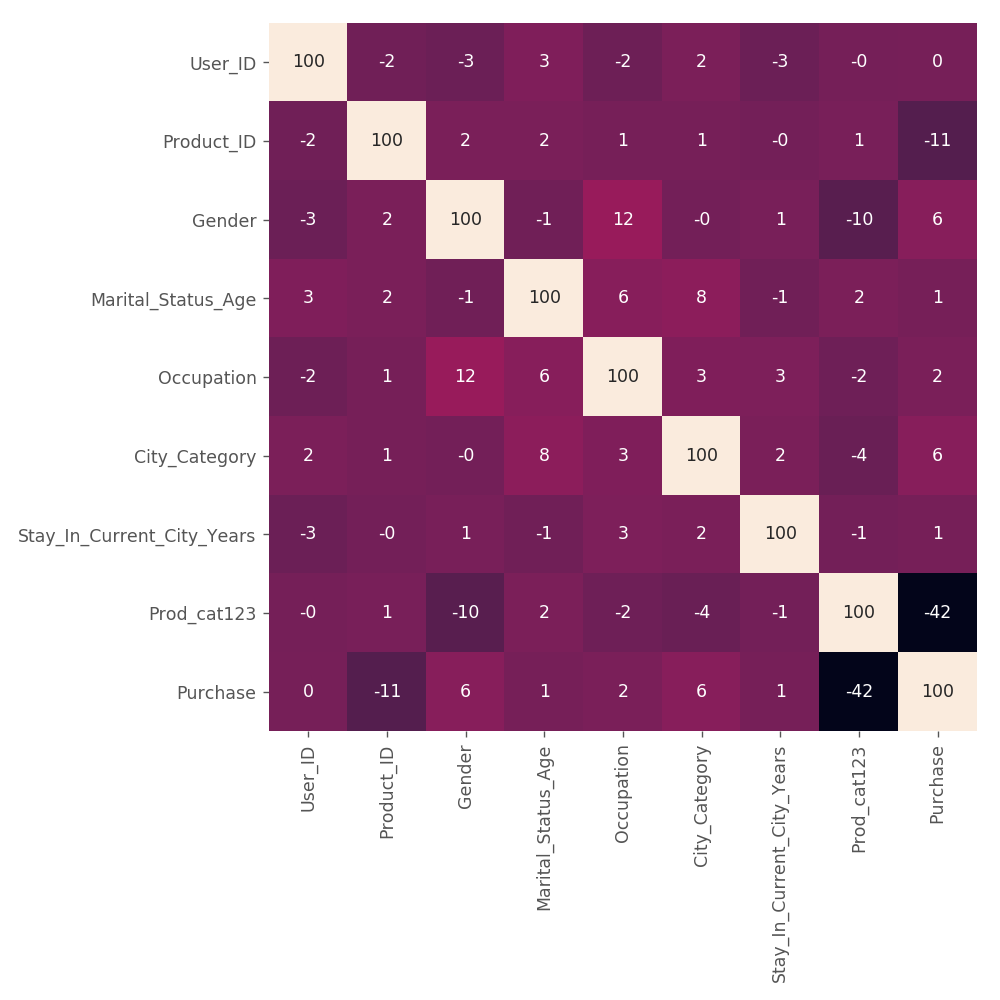

In [6]:
# show correlation again
_ , axsn2 = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn2, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn2.tick_params(axis = 'x',rotation = 90.0)
axsn2.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

Combine Age, Marital Status and City Category (old idea)

In [7]:
# temp_Age_Marital_City_o = df_cpy.loc[:,['Age','Marital_Status', 'City_Category']].astype(str)
# # merge content of columns
# temp_Age_Marital_City_o = temp_Age_Marital_City_o.Age +'-'\
#         +temp_Age_Marital_City_o.Marital_Status +'-'\
#         +temp_Age_Marital_City_o.City_Category    
# # assign name to new column
# df_cpy.insert(len(df_cpy.columns)-2, 'Age_Marital_City', temp_Age_Marital_City_o)
# df_cpy.drop(labels = ['Age','Marital_Status','City_Category'],\
#               inplace=True, axis = 1)
# # convert to numeric values
# df_cpy['Age_Marital_City'] = df_cpy['Age_Marital_City'].astype('category').cat.codes

As Gender and Product category 1,2,3 are somewhat correlated, combine them

In [8]:
# Combine Prod cat123 and Gender
temp_cpy_G_cat = df_cpy.loc[:,['Gender', 'Prod_cat123']].astype(str)
temp_cpy_G_cat = temp_cpy_G_cat.Gender + '-' + temp_cpy_G_cat.Prod_cat123
df_cpy.insert(len(df_cpy.columns)-1, 'Gender_Prod_cat123', temp_cpy_G_cat)
df_cpy.drop(labels = ['Gender','Prod_cat123'], inplace=True, axis = 1)
# convert to numeric values
df_cpy['Gender_Prod_cat123'] = df_cpy['Gender_Prod_cat123'].astype('category').cat.codes

Even out stay in current city

In [9]:
df_cpy.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.replace(['0', '1'], '0-1')
df_cpy.Stay_In_Current_City_Years.replace(['2', '3', '4+'], '2+', inplace = True)
df_cpy.Stay_In_Current_City_Years.value_counts()
df_cpy['Stay_In_Current_City_Years'] = df_cpy['Stay_In_Current_City_Years'].astype('category').cat.codes

Plot updated confusion matrix

<IPython.core.display.Javascript object>


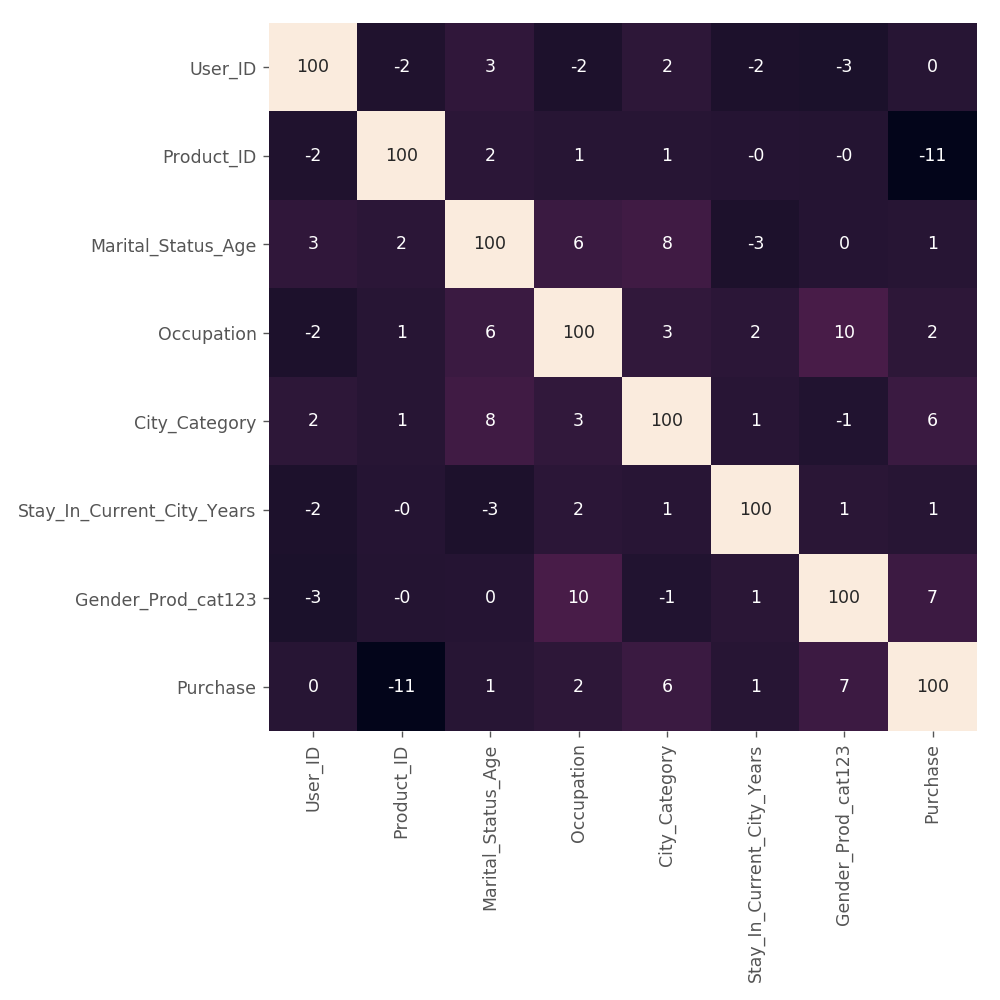

In [10]:
# show correlation
_ , axsn3 = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn3, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn3.tick_params(axis = 'x',rotation = 90.0)
axsn3.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

### Proceed with one-hot encoding (All features are numeric now)

In [11]:
df_cpy.dtypes

User_ID                       int64
Product_ID                    int16
Marital_Status_Age             int8
Occupation                    int64
City_Category                  int8
Stay_In_Current_City_Years     int8
Gender_Prod_cat123            int16
Purchase                      int64
dtype: object

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder_list = []
X_features = ()

for i in range(len(df_cpy.columns)-1):
    # outputs sparse matrix by default
    this_encoder = OneHotEncoder()
    X_features += (this_encoder.fit_transform(df_cpy.iloc[:,i].values.reshape(-1,1)), )
    # keep encoder
    encoder_list.append(this_encoder)

Stack features and save them to file (optional)

In [13]:
from scipy.sparse import hstack, save_npz
X = hstack( X_features )
save_npz('features.npz', X)
X.shape, type(X)

((550068, 10027), scipy.sparse.coo.coo_matrix)

Same for targets (optional)

In [14]:
# save target too
from numpy import save
save('target.npy', df_cpy.Purchase.values, allow_pickle=True, fix_imports=True)